In [2]:
import numpy as np
from matplotlib import pyplot as plt
import timeit

%matplotlib inline
%load_ext autoreload
%autoreload 2

import montecarlo as mc
from montecarlo import cython_mcmc

import h5py
from pathlib import Path
from jobmanager import *

In [ ]:
def time(steps, size): return steps * size**2 * 8 / 400**2 / 1e4
runtime_irelevant_loops = np.array(
                                    [len(config[k]) for k in config['loop_over']
                                      if k not in ['N_system','N_steps']]
                                    ).prod()

runtime = runtime_irelevant_loops * time(config['N_steps'], config['N_system']).sum() / 60 / 60 / 24
print(f'runtime in days = {runtime}')

In [ ]:
f, (ax,ax2) = plt.subplots(1,2)
ax.scatter(N_system, time)
x = np.linspace(0,400,400)
y = config['N_steps'] * x**2 * (11/400**2/1e4) 
ax.plot(x,y)
ax.legend()
time.sum() /60 /60


In [26]:
%%time
working_dir = Path('./really_long_classical_run')
result_filename = working_dir / "results.hdf5"
job_dir =  working_dir / "jobs"

with h5py.File(result_file, "r") as f:
    config = dict(f.attrs)

out = []
for job_filename in job_dir.iterdir():
    with h5py.File(job_filename, 'r') as job_file:
        #loop over the datasets, ie energy, magnetisation etc
        out.append((job_file.attrs['N_system'],
                    job_file.attrs['N_steps'],
                    job_file.attrs['runtime']))
            
N_system, N_steps, time = np.array(out).T

## Setup a new job from scratch

In [6]:
config = dict(
              mcmc_routine='quantum_cython_mcmc',
              N_steps = 10**3,
              N_system = np.array([16,32,64,128]),
              mu = 0,
              beta = np.linspace(0.1,1.5,30),
              V=-1,
              U=np.linspace(0,3,30),
              alpha=1.5,
              return_names = True,
              #this is necessary for hd5 to know how to save it
              loop_over = np.array(['N_system', 'U', 'beta'], dtype=h5py.special_dtype(vlen=str)),
            )

working_dir = Path('./small_quantum_run')
setup_mcmc(config, working_dir)

config = read_config_file(working_dir)
config

#!/usr/bin/env bash
#PBS -N small_quantum_run
#PBS -lselect=1:ncpus=1:mem=1gb:avx=true
#PBS -lwalltime=24:00:00
#PBS -J 1-3600

echo ------------------------------------------------------
echo -n 'Job is running on node '; cat $PBS_NODEFILE
echo ------------------------------------------------------
echo PBS: qsub is running on $PBS_O_HOST
echo PBS: originating queue is $PBS_O_QUEUE
echo PBS: executing queue is $PBS_QUEUE
echo PBS: working directory is $PBS_O_WORKDIR
echo PBS: execution mode is $PBS_ENVIRONMENT
echo PBS: job identifier is $PBS_JOBID
echo PBS: job name is $PBS_JOBNAME
echo PBS: node file is $PBS_NODEFILE
echo PBS: current home directory is $PBS_O_HOME
echo PBS: PATH = $PBS_O_PATH
echo ------------------------------------------------------

module load intel-suite anaconda3/personal
. /home/tch14/anaconda3/etc/profile.d/conda.sh
conda activate idp

cd /rds/general/user/tch14/home/Falicok-Kimball-Monte-Carlo/small_quantum_run
let "JOB_ID = PBS_ARRAY_INDEX - 1"
run_mcmc --

{'mcmc_routine': 'quantum_cython_mcmc',
 'N_steps': 1000,
 'N_system': array([ 16,  32,  64, 128]),
 'mu': 0,
 'beta': array([0.1       , 0.14827586, 0.19655172, 0.24482759, 0.29310345,
        0.34137931, 0.38965517, 0.43793103, 0.4862069 , 0.53448276,
        0.58275862, 0.63103448, 0.67931034, 0.72758621, 0.77586207,
        0.82413793, 0.87241379, 0.92068966, 0.96896552, 1.01724138,
        1.06551724, 1.1137931 , 1.16206897, 1.21034483, 1.25862069,
        1.30689655, 1.35517241, 1.40344828, 1.45172414, 1.5       ]),
 'V': -1,
 'U': array([0.        , 0.10344828, 0.20689655, 0.31034483, 0.4137931 ,
        0.51724138, 0.62068966, 0.72413793, 0.82758621, 0.93103448,
        1.03448276, 1.13793103, 1.24137931, 1.34482759, 1.44827586,
        1.55172414, 1.65517241, 1.75862069, 1.86206897, 1.96551724,
        2.06896552, 2.17241379, 2.27586207, 2.37931034, 2.48275862,
        2.5862069 , 2.68965517, 2.79310345, 2.89655172, 3.        ]),
 'alpha': 1.5,
 'return_names': True,
 'loop_ov

In [8]:
config = read_config_file(working_dir)
incomplete = job_completion(working_dir)

print(working_dir)
print(f'Remaining: {len(incomplete)} Total: {total_jobs(config)}\n')
!qstat
!qstat -q

small_quantum_run
Remaining: 3600 Total: 3600


server: cx1

Queue            Memory CPU Time Walltime Node   Run   Que   Lm  State
---------------- ------ -------- -------- ---- ----- ----- ----  -----
express            --      --       --     --      0     0   --   E S
v1_submit          --      --       --     --      0     0   --   E R
v1_throughput24    --      --       --     --     44     2   --   E R
v1_debug           --      --       --     --      1     6   --   E R
v1_multinode24     --      --       --     --      8    13   --   E R
v1_multinode48     --      --       --     --      7    16   --   E R
v1_largemem24      --      --       --     --      2     0   --   E R
v1_throughput2a    --      --       --     --   5661    20   --   E R
v1_general24a      --      --       --     --     90     1   --   E R
pqchemlab1         --      --    24:00:00  --      0     0   --   E R
pqchemeng          --      --    168:00:0  --      3     0   --   E R
pqeph              --      

In [89]:
%%time
working_dir = Path('./really_long_classical_run')
gather_mcmc(working_dir, do_all = False)

INFO:jobmanager:Number of Jobs to copy in: 0
INFO:jobmanager:Job IDs: []...


A Jupyter Widget

INFO:jobmanager:missing : 0 of 0 total jobs that need to be inserted (overall 2000)
INFO:jobmanager:File size: 48.00Gb


CPU times: user 34.1 ms, sys: 532 ms, total: 566 ms
Wall time: 565 ms


['energies', 'magnetisations', 'numbers']
['alpha' 'N_system' 'beta']


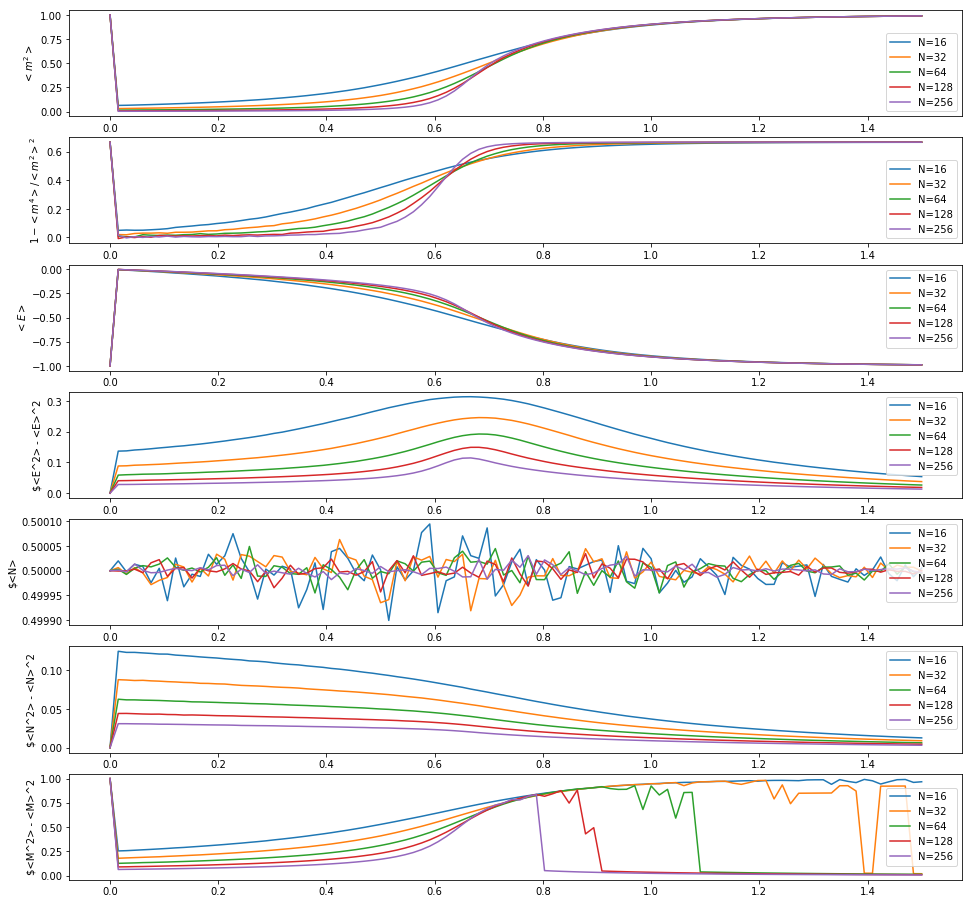

In [90]:
%%time
working_dir = Path('./really_long_classical_run')
result_filename = working_dir / 'results.hdf5'

with h5py.File(result_filename, 'r') as data:
    print(list(data.keys()))
    print(data.attrs['loop_over'])
    
    f, axs = plt.subplots(7, figsize = (16,16))
    

    N_systems = data.attrs['N_system']
    betas = data.attrs['beta']
    alphas = data.attrs['alpha']
    
    alpha_i = 2
    skip = 1000

    for i,N_system in enumerate(N_systems):
        #axes: N_system, beta, alpha, mcmc_step
        slic = (alpha_i, i, ..., slice(skip,None))
        
        e = data['energies'][slic] / N_system
        m = data['magnetisations'][slic] /  N_system
        n = data['numbers'][slic] /  N_system
        

        axs[0].plot(betas, (m**2).mean(axis=-1), label = f'N={N_system}')
        axs[0].set(ylabel = r'$<m^2>$')
        
        axs[1].plot(betas, 1-(m**4).mean(axis=-1)/(m**2).mean(axis=1)**2/3, label = f'N={N_system}')
        axs[1].set(ylabel = r'$1-<m^4>/<m^2>^2$')
        
        axs[2].plot(betas, e.mean(axis=-1), label = f'N={N_system}')
        axs[2].set(ylabel = r'$<E>$')
        axs[3].plot(betas, e.std(axis=-1), label = f'N={N_system}')
        axs[3].set(ylabel = r'$<E^2> - <E>^2')
        
        
        axs[4].plot(betas, n.mean(axis=-1), label = f'N={N_system}')
        axs[4].set(ylabel = r'$<N>')
        axs[5].plot(betas, n.std(axis=-1), label = f'N={N_system}')
        axs[5].set(ylabel = r'$<N^2> - <N>^2')
        
        axs[6].plot(betas, m.std(axis=-1), label = f'N={N_system}')
        axs[6].set(ylabel = r'$<M^2> - <M>^2')
        

    for a in axs: a.legend()

In [ ]:
wdir = Path('./classical_run/logs')
def get_log(number, e_or_o = 'o'):
    filename = wdir / f'MCMC_simulation.{e_or_o}2124202.{number}'
    with open(filename, 'r') as f:
        output = f.read()
    return output.split('\n')
    
for n in job_completion(Path('./classical_run')):
    print(n, get_log(n)[1], get_log(n, 'e'))
    
#for n in range(1,100):
#    print(n, get_log(n)[1])

In [ ]:
from quantum_montecarlo import quantum_cython_mcmc

config = dict(N_steps = 10**4,
              N_system = 128,
              mu = 0,
              beta = 0.1,
              V=-1,
              alpha=1.5,
              U = 1,
              return_names = True,
              #this is necessary for hd5 to know how to save it
            )

quantum_cython_mcmc(**config)

In [101]:
1-1

0